In [2]:
from HODDIES import HOD


In [3]:
param = {}
param['tracers'] = ['ELG']
param['hcat'] = {}
param['hcat']['Abacus'] = {}
param['hcat']['Abacus']['sim_name'] = 'AbacusSummit_base_c000_ph000'
param['hcat']['Abacus']['halo_lc'] = True
param['hcat']['Abacus']['z_simu'] = [.8,.875, 0.95,1.025,1.1] # You also can provide a list of shells ie [.8,.875, 0.95,1.025,1.1] for ELG zbin 0.8-1.1
param['nthreads'] = 128

In [4]:
HOD_obj = HOD(path_to_abacus_sim='/global/cfs/cdirs/desi/cosmosim/Abacus', **param)


Set number of threads to 128


Load Compaso cat from ['/global/cfs/cdirs/desi/cosmosim/Abacus/halo_light_cones/AbacusSummit_base_c000_ph000/z0.800', '/global/cfs/cdirs/desi/cosmosim/Abacus/halo_light_cones/AbacusSummit_base_c000_ph000/z0.875', '/global/cfs/cdirs/desi/cosmosim/Abacus/halo_light_cones/AbacusSummit_base_c000_ph000/z0.950', '/global/cfs/cdirs/desi/cosmosim/Abacus/halo_light_cones/AbacusSummit_base_c000_ph000/z1.025', '/global/cfs/cdirs/desi/cosmosim/Abacus/halo_light_cones/AbacusSummit_base_c000_ph000/z1.100'] ...
Done took 00:01:39
Compute columns...
Done took  00:00:06
AbacusSummit_base_c000_ph000 at [0.8, 0.875, 0.95, 1.025, 1.1] loaded, took 00:01:47
Initialize Abacus c000 cosmology


In [5]:
hod_param_mHMQ_cf_mNFW = {'M_1':13, 'M_0':11.2, 'HOD_model': 'mHMQ',
  'log_Mcent': 11.64, 'Ac':.1, 'As':.41,
  'exp_frac': 0.58, 'exp_scale':6.14, 'nfw_rescale':0.67, # param for mofify NFW profile. Set exp_frac to 0 to desactivate the feature
  'alpha': 0.81, 'conformity_bias':True, 'gamma': 5.47,
  'f_sigv': 1.63, 'pmax':1, 'sigma_M': 0.3, 'density':False}
  
HOD_obj.args['ELG'].update(hod_param_mHMQ_cf_mNFW)


In [6]:
cat = HOD_obj.make_mock_cat()

Create mock catalog for ['ELG']
Run HOD for ELG
No density set
HOD Computed 5.377427816390991
Start satellite assignement


/global/u1/a/arocher/Code/postdoc/HOD/Dev/HODDIES/HODDIES/utils.py:499: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../HODDIES/utils.py", line 415:
@njit(fastmath=True)
def get_etavir_nfw(c): 
^

  etaVir = get_etavir_nfw(c[i])*nfw_rescale
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/numba/parfors/parfor.py:2395: NumbaPerformanceWarning: 
prange or pndindex loop will not be executed in parallel due to there being more than one entry to or exit from the loop (e.g., an assertion).

File "../HODDIES/utils.py", line 487:
def compute_fast_NFW(x_h, y_h, z_h, vx_h, vy_h, vz_h, c, M, Rvir, rd_pos, rd_vel, exp_frac=0, exp_scale=1, nfw_rescale=1, vrms_h=None, f_sigv=None, v_infall=None, v

Satellite assignement done 6.58354926109314
ELG mock catalogue done 7.7283055782318115
5395175 central galaxies, 201618 satellites, fraction of satellite 0.04 
Done overall time  ELG 16.879262447357178


In [7]:
from abacusnbody.hod.prepare_sim import gen_rand, is_in_cube
import numpy as np 

distance = HOD_obj.cosmo.comoving_radial_distance
rng = np.random.RandomState(seed=10)
rd_pos, dist_rd = gen_rand(cat.size, distance(cat['redshift_interp'].min()), 
                        distance(cat['redshift_interp'].max()), 4,2000, 10, HOD_obj.origin, rng)

masked randoms =  89.86299386094858


In [ ]:
from abacusnbody.hod.prepare_sim import gen_rand, is_in_cube, get_vertices_cube

def mask_outter_gal(pos_rsd, origins, Lbox, offset, chi_max):
    x_cart, y_cart, z_cart = pos_rsd
    origin = origins[0]
    box0 = np.array([0.0, 0.0, 0.0]) - origin
    if (
        origins.shape[0] > 1
    ):  # not true of only the huge box where the origin is at the center
        assert origins.shape[0] == 3
        assert np.all(origins[1] + np.array([0.0, 0.0, Lbox]) == origins[0])
        assert np.all(origins[2] + np.array([0.0, Lbox, 0.0]) == origins[0])
        box1 = np.array([0.0, 0.0, Lbox]) - origin
        box2 = np.array([0.0, Lbox, 0.0]) - origin

    # vertices of a cube centered at 0, 0, 0
    vert = get_vertices_cube(units=Lbox / 2.0)

    # remove edges because this is inherent to the light cone catalogs
    x_vert = vert[:, 0]
    y_vert = vert[:, 1]
    z_vert = vert[:, 2]
    vert[x_vert < 0, 0] += offset
    vert[x_vert > 0, 0] -= offset
    vert[y_vert < 0, 1] += offset
    vert[z_vert < 0, 2] += offset
    if origins.shape[0] == 1:  # true of the huge box where the origin is at the center
        vert[y_vert > 0, 1] -= offset
        vert[z_vert > 0, 2] -= offset

    # vertices for all three boxes
    vert0 = box0 + vert
    if origins.shape[0] > 1 and chi_max >= (
        Lbox - offset
    ):  # not true of only the huge boxes and at low zs for base
        vert1 = box1 + vert
        vert2 = box2 + vert

    # mask for whether or not the coordinates are within the vertices
    mask0 = is_in_cube(x_cart, y_cart, z_cart, vert0)
    if origins.shape[0] > 1 and chi_max >= (Lbox - offset):
        mask1 = is_in_cube(x_cart, y_cart, z_cart, vert1)
        mask2 = is_in_cube(x_cart, y_cart, z_cart, vert2)
        mask = mask0 | mask1 | mask2
    else:
        mask = mask0

    mask_pos = np.vstack((x_cart[mask], y_cart[mask], z_cart[mask])).T
    mask_pos += origin
    return mask_pos

In [64]:
mask_pos = mask_outter_gal(pos_rsd.T, HOD_obj.origin, Lbox=2000, offset=10, chi_max=distance(cat['redshift_interp'].max()))

In [78]:
distance(cat['redshift_interp'].max())

array(2512.607, dtype=float32)

In [ ]:
rd_pos, dist_rd = gen_rand(cat.size, distance(cat['redshift_interp'].min()), 
                        distance(cat['redshift_interp'].max()), 4,2000, 10, HOD_obj.origin, rng)

array([[-989.7537 , -986.09357, -982.5899 , ...,  943.557  ,  945.4003 ,
         940.92957],
       [ 999.9987 ,  997.5151 ,  998.21857, ..., -926.23676, -912.0099 ,
        -977.5846 ],
       [-917.9314 , -865.4202 , -837.9705 , ..., -961.23334, -970.0714 ,
        -963.3821 ]], dtype=float32)

In [30]:
dist_rd

array([2020.92712393, 2487.5913806 , 2441.14306259, ..., 2347.39525406,
       2496.96621465, 2403.98711336])

In [52]:
from pycorr import TwoPointCorrelationFunction
pimax = 40
edges = np.array([ 0.04641589,  0.06812921,  0.1       ,  0.14677993,  0.21544347,
         0.31622777,  0.46415888,  0.68129207,  1.        ,  1.46779927,
         2.15443469,  3.16227766,  4.64158883,  6.81292069, 10.        ,
        14.67799268, 21.5443469 , 31.6227766]), np.linspace(-pimax,pimax,pimax*2+1)

result = TwoPointCorrelationFunction('rppi', edges, 
                                        data_positions1=[cat['x'], cat['y'], cat['z']],
                                        randoms_positions1=rd_pos.T, los='z', position_type='xyz',
                                        boxsize=None, nthreads=256)

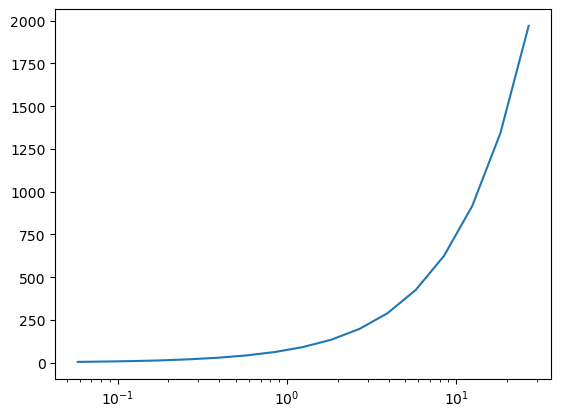

In [51]:
from matplotlib import pyplot as plt
rp, wp = result(return_sep=True, pimax=40)

plt.semilogx(rp,rp*wp)

In [11]:
edges = np.array([ 0.26101572,  0.31622777,  0.38311868,  0.46415888,  0.56234133,
         0.68129207,  0.82540419,  1.        ,  1.21152766,  1.46779927,
         1.77827941,  2.15443469,  2.61015722,  3.16227766,  3.83118685,
         4.64158883,  5.62341325,  6.81292069,  8.25404185, 10.        ,
        12.11527659, 14.67799268, 17.7827941 , 21.5443469 , 26.10157216,
        31.6227766 ]), np.linspace(-1,1,201)

result_smu = TwoPointCorrelationFunction('smu', edges, 
                                        data_positions1=[cat['x'], cat['y'], cat['z']],
                                        randoms_positions1=rd_pos.T, los='z', position_type='xyz',
                                        boxsize=None, nthreads=256)

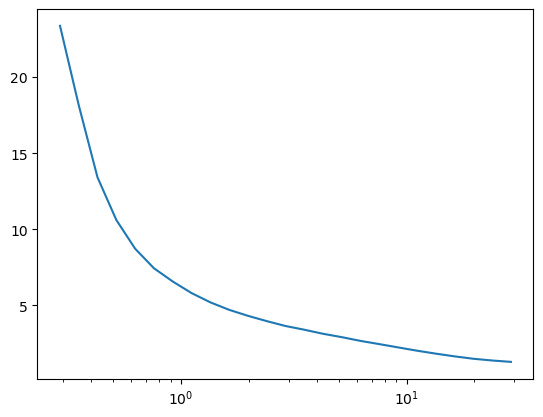

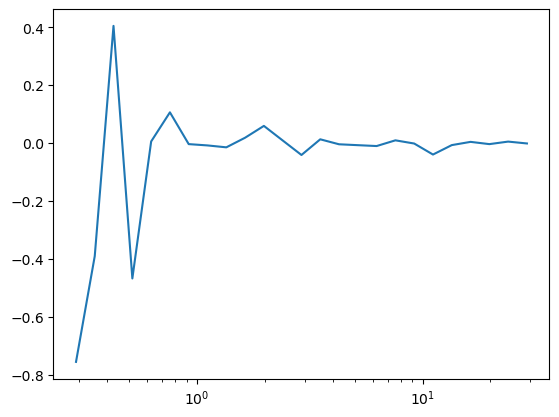

In [12]:
from matplotlib import pyplot as plt
s, (xi0, xi2) = result_smu(return_sep=True, ells=[0,2])

plt.semilogx(s,s*xi0)
plt.show()
plt.semilogx(s,s*xi2)

In [13]:
rsd_factor = 1 / (1 / (1 + cat['redshift_interp']) * 100 * HOD_obj.cosmo.efunc(cat['redshift_interp']))
pos_rsd1 = [cat[p] + rsd_factor*cat[f'v{p}'] for p in 'xyz']


In [84]:
def vector_projection(vector, direction):
    """
    Vector components of given vectors in a given direction.

    .. math::
       \mathbf{v}_\mathbf{d} &= (\mathbf{v} \cdot \hat{\mathbf{d}}) \hat{\mathbf{d}} \\
       \hat{\mathbf{d}} &= \frac{\mathbf{d}}{\|\mathbf{d}\|}

    Adapted from https://github.com/bccp/nbodykit/blob/master/nbodykit/transform.py

    Parameters
    ----------
    vector : array
        Array of vectors to be projected (along last dimension).

    direction : array
        Projection direction, 1D or 2D (if different direction for each input ``vector``) array.
        It will be normalized.

    Returns
    -------
    projection : array
        Vector components of the given vectors in the given direction.
        Same shape as input ``vector``.
    """
    direction = np.atleast_2d(direction)
    direction = direction / (direction ** 2).sum(axis=-1)[..., None] ** 0.5
    projection = (vector * direction).sum(axis=-1)

    return projection[..., None] * direction

def _distance(position):
    """Return cartesian distance, taking coordinates along ``position`` last axis."""
    return np.sqrt((position**2).sum(axis=-1))

def rsd_position(pos,vel, f=1., los=None):
        r"""
        Return :attr:`position` with redshift space distortions applied.

        Parameters
        ----------
        f : callable, float
            Factor to apply to :attr:`velocity` to obtain the RSD displacement in :attr:`position` units.
            If a callable, take the (flattened) distance to the observer as input, i.e. displacement is given by :math:`f(r) \psi'.
            Else, a float to multiply the velocity.

        los : 'x', 'y', 'z'; int,
        3-vector of int, default=None
            Line of sight :math:`\hat{\eta}` for RSD.
            If ``None``, use local line of sight.
        """
        if los is None:
            los = pos / np.sqrt((np.array(pos)**2).sum(axis=-1))[:, None]
        else:
            los = _get_los(los)
        rsd = vector_projection(vel, los)
        iscallable = callable(f)
        if iscallable:
            rsd *= f(distance())
        else:
            rsd *= f
        return pos+rsd
        

pos = cat['x'], cat['y'], cat['z']
vel = cat['vx'], cat['vy'], cat['vz']
H_0=100
f= 1 / (1 / (1 + cat['redshift_interp']) * H_0 * HOD_obj.cosmo.efunc(cat['redshift_interp']))

pos_rsd = rsd_position(np.vstack(pos).T, np.vstack(vel).T, f=f[:,None])



In [85]:
pimax = 40
edges = np.array([ 0.04641589,  0.06812921,  0.1       ,  0.14677993,  0.21544347,
         0.31622777,  0.46415888,  0.68129207,  1.        ,  1.46779927,
         2.15443469,  3.16227766,  4.64158883,  6.81292069, 10.        ,
        14.67799268, 21.5443469 , 31.6227766]), np.linspace(-pimax,pimax,pimax*2+1)

result = TwoPointCorrelationFunction('rppi', edges, 
                                        data_positions1=pos_rsd.T,
                                        randoms_positions1=rd_pos.T, position_type='xyz',
                                        boxsize=None, nthreads=256)

In [86]:
edges = np.array([ 0.26101572,  0.31622777,  0.38311868,  0.46415888,  0.56234133,
         0.68129207,  0.82540419,  1.        ,  1.21152766,  1.46779927,
         1.77827941,  2.15443469,  2.61015722,  3.16227766,  3.83118685,
         4.64158883,  5.62341325,  6.81292069,  8.25404185, 10.        ,
        12.11527659, 14.67799268, 17.7827941 , 21.5443469 , 26.10157216,
        31.6227766 ]), np.linspace(-1,1,201)

result_smu_rsd = TwoPointCorrelationFunction('smu', edges, 
                                        data_positions1=pos_rsd.T,
                                        randoms_positions1=rd_pos.T, position_type='xyz',
                                        boxsize=None, nthreads=256)

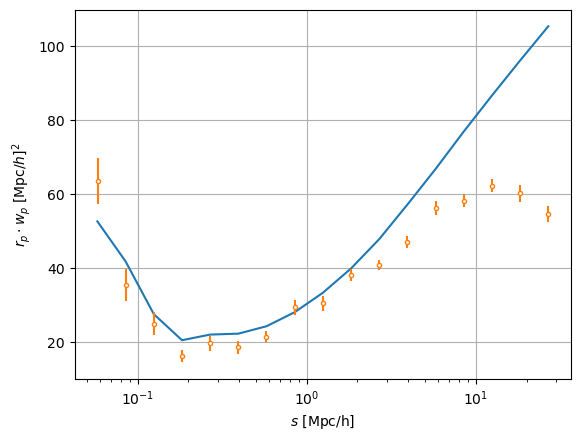

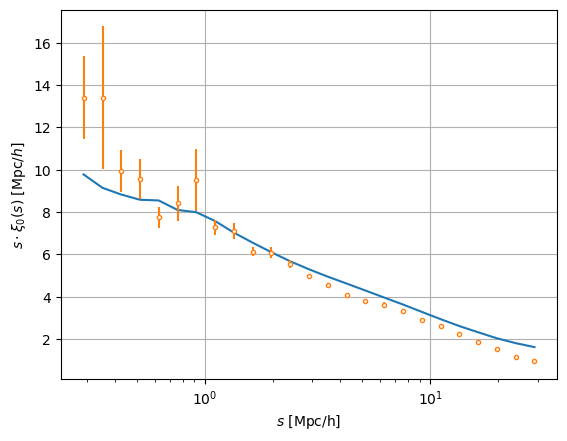

Text(0.5, 0, '$s$ [Mpc/h]')

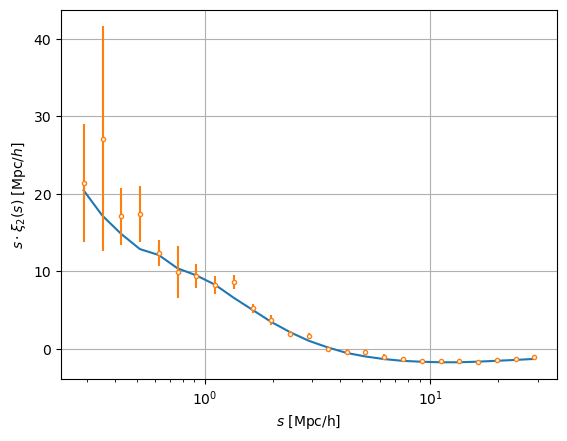

In [87]:
from matplotlib import pyplot as plt
s, (xi0, xi2) = result_smu_rsd(return_sep=True, ells=[0,2])




def read_pc(path_data = '/global/cfs/cdirs/desi/survey/catalogs/edav1/xi/sv3/',
            stat = 'rppi',
            tracer = 'ELG',
            region = 'NScomb',
            zlim = '0.8_1.6',
            njk = 128,
            nran = 18,
            weights = 'default_angular_bitwise_FKP',
            binning = 'log',
            split='_split20',
            fn=None,
            n_rebin = 1,
            n_rebin_post_cut=1,
            bin_inf=None,
            bin_sup=None):
    if fn is None:
        name = f'allcounts_{tracer}_{region}_{zlim}_{weights}_{binning}_njack{njk}_nran{nran}{split}.npy'
        fn = os.path.join(path_data, stat, name)
        return TwoPointCorrelationFunction.load(fn)[::n_rebin][bin_inf:bin_sup][::n_rebin_post_cut]
    else:
        return TwoPointCorrelationFunction.load(fn)[::n_rebin][bin_inf:bin_sup][::n_rebin_post_cut]
tr = 'ELG'
zbin = [0.8,1.1]
smu_res = read_pc(fn=f'/global/cfs/cdirs/desi/users/arocher/Y1/v1.5pip/smu/allcounts_{tr+"_LOPnotqso" if tr == "ELG" else tr}_GCcomb_{zbin[0]}_{zbin[1]}_pip_angular_bitwise_log_njack128_nran4_split20.npy',n_rebin=1, bin_inf=17, bin_sup=-6)
s_data, xi_data, sig_xi_data = smu_res(return_sep=True, return_std=True,  ells=[0,2])


rppi_res = read_pc(fn=f'/global/cfs/cdirs/desi/users/arocher/Y1/v1.5pip/rppi/allcounts_{tr+"_LOPnotqso" if tr == "ELG" else tr}_GCcomb_{zbin[0]}_{zbin[1]}_pip_angular_bitwise_log_njack128_nran4_split20.npy',n_rebin=2, bin_inf=4, bin_sup=-3)
rp_data, wp_data, sig_wp_data = rppi_res(return_sep=True, return_std=True,pimax=40)

rp, wp = result(return_sep=True, pimax=80)

plt.plot(rp,rp*wp)
plt.errorbar(rp_data,rp_data*wp_data, rp_data*sig_wp_data, fmt='.',
                        markerfacecolor='w')
plt.xscale('log')
plt.grid(True)
plt.ylabel('$r_{p} \cdot w_{p}$ [$\mathrm{{Mpc}}/h$]$^2$')
plt.xlabel('$s$ [Mpc/h]')
plt.show()

s, (xi0, xi2) = result_smu_rsd(return_sep=True, ells=[0,2])

plt.plot(s,s*xi0)
plt.errorbar(s_data,s_data*xi_data[0], s_data*sig_xi_data[0], fmt='.',
                        markerfacecolor='w')
plt.xscale('log')
plt.grid(True)
plt.ylabel(r'$s \cdot \xi_{{{:d}}}(s)$ [$\mathrm{{Mpc}}/h$]'.format(0))
plt.xlabel('$s$ [Mpc/h]')
plt.show()
plt.plot(s,s*xi2)
plt.errorbar(s_data,s_data*xi_data[1], s_data*sig_xi_data[1], fmt='.',
                        markerfacecolor='w')
plt.xscale('log')
plt.grid(True)
plt.ylabel(r'$s \cdot \xi_{{{:d}}}(s)$ [$\mathrm{{Mpc}}/h$]'.format(2))
plt.xlabel('$s$ [Mpc/h]')
